# SEIS 764_Transfer Learning Project

### ---- Using a Transfer Learning Model (derived from pretrained CNN Model called VGG19) in order to do multiclassification (6 Classes)---

## Step1:Importing all the required libraries

In [ ]:
#--------------------- Google Colab Code ------------------------------------
#Source: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=tMce8muBqXQP
# Tensorflow with GPU
%tensorflow_version 2.x
import tensorflow as tf
import timeit

# Enabling and testing the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Observe TensorFlow speedup on GPU relative to CPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# knowing the gpu name
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
#print(gpu_info)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print('CPU (s):',cpu_time)
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print('GPU (s):',gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Found GPU at: /device:GPU:0
CPU (s): 3.6598655870002403
GPU (s): 0.11089098299999023
GPU speedup over CPU: 33x


In [ ]:
#Imported pandas library because it contains a built in function called read_csv() which loads the dataset into a dataframe
#For loading data
import pandas as pd

#For analyzing data
import numpy as np

#For visualizing data
import seaborn as sns
import matplotlib.pyplot as plt

!pip install pandas==0.25.3
!pip install numpy==1.17.4
!pip install seaborn==0.9.0
print('Pandas Version Downloaded/Imported for Usage in this Notebook: V {}'.format(pd.__version__))
print('Numpy Version Downloaded/Imported for Usage in this Notebook: V {}'.format(np.__version__))
print('Seaborn Version Downloaded/Imported for Usage in this Notebook: V {}'.format(sns.__version__))

Pandas Version Downloaded/Imported for Usage in this Notebook: V 0.25.3
Numpy Version Downloaded/Imported for Usage in this Notebook: V 1.17.4
Seaborn Version Downloaded/Imported for Usage in this Notebook: V 0.9.0


## Step2:Test_Train Split of Images to feed as input to the pretrained CNN Model

In [ ]:
#--------------------- Google Colab Code ------------------------------------
#Mounted the google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

import os
os.chdir('/content/drive/My Drive/SEIS_764_Group_Project/Big Cat') #specifying the file path to the gdrive folder containing this colab notebook & the raw data 

Mounted at /content/drive


In [ ]:
os.getcwd() # finding the current working directory

'/content/drive/.shortcut-targets-by-id/1Fz_TNyhsvVwZFl4QgDlrt_ileWYOq-P_/SEIS_764_Group_Project/Big Cat'

In [ ]:
!ls -la #viewing the content of the current working directory

total 261
-rw------- 1 root root      0 Nov  7 20:06 ls
drwx------ 2 root root   4096 Nov  8 22:10 MetaData
drwx------ 2 root root   4096 Nov  8 21:38 Notes
drwx------ 2 root root   4096 Nov  8 15:14 RawData_Balanced
drwx------ 2 root root   4096 Nov  8 22:25 RawData_Extracted
-rw------- 1 root root   8360 Nov  8 21:30 Serengeti.ipynb
-rw------- 1 root root 238009 Nov  8 22:31 TL_Project_Colab.ipynb
drwx------ 2 root root   4096 Nov  7 15:33 z


## Step3: Data Transformation of Images for aiding CNN Models Generalization Ability

Google Search: CNN image generator

Data Source:https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [ ]:
#Unzipping the files and saving them onto the gdrive causes a 4gb storage burden
!unzip  "/content/drive/My Drive/SEIS_764_Group_Project/Big Cat/MetaData/SnapshotSerengetiS01.json.zip" -d MetaData
!unzip  "/content/drive/My Drive/SEIS_764_Group_Project/Big Cat/MetaData/SnapshotSerengetiS02.json.zip" -d MetaData

Archive:  /content/drive/My Drive/SEIS_764_Group_Project/Big Cat/MetaData/SnapshotSerengetiS01.json.zip
replace MetaData/SnapshotSerengetiS01.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: MetaData/SnapshotSerengetiS01.json  
Archive:  /content/drive/My Drive/SEIS_764_Group_Project/Big Cat/MetaData/SnapshotSerengetiS02.json.zip
replace MetaData/SnapshotSerengetiS02.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: MetaData/SnapshotSerengetiS02.json  


Downloading Images for the class label of zebra

In [ ]:
# download_lila_subset.py
#
# Example of how to download a list of files from LILA, e.g. all the files
# in a data set corresponding to a particular species.
#

#%% Constants and imports

import json
import urllib.request
import os
from tqdm import tqdm
from multiprocessing.pool import ThreadPool

# SAS URLs come from:
#
# http://lila.science/?attachment_id=792
#
# In this example, we're using the Missouri Camera Traps data set
sas_url = 'https://lilablobssc.blob.core.windows.net/snapshotserengeti-unzipped?st=2020-01-01T00%3A00%3A00Z&se=2034-01-01T00%3A00%3A00Z&sp=rl&sv=2019-07-07&sr=c&sig=/DGPd%2B9WGFt6HgkemDFpo2n0M1htEXvTq9WoHlaH7L4%3D'

# This assumes you've downloaded the metadata file from LILA
json_filename = r"/content/drive/My Drive/SEIS_764_Group_Project/Big Cat/MetaData/SnapshotSerengetiS01.json"

output_dir = r'/content/drive/My Drive/SEIS_764_Group_Project/Big Cat/RawData_Extracted/zebra'

species_of_interest = 'zebra'

# We will demonstrate two approaches to downloading, one that loops over files
# and downloads directly in Python, another that uses AzCopy.
#
# AzCopy will generally be more performant and supports resuming if the 
# transfers are interrupted.  It assumes that azcopy is on the system path.
use_azcopy_for_download = False

overwrite_files = False

# Number of concurrent download threads (when not using AzCopy)
n_download_threads = 50


#%% Environment prep and derived constants

base_url = sas_url.split('?')[0]
sas_token = sas_url.split('?')[1]
os.makedirs(output_dir,exist_ok=True)


#%% Open the metadata file

with open(json_filename, 'r') as f:
    data = json.load(f)

categories = data['categories']
annotations = data['annotations']
images = data['images']


#%% Build a list of image files (relative path names) that match the target species

# Retrieve the category ID we're interested in
category_of_interest = list(filter(lambda x: x['name'] == species_of_interest, categories))
assert len(category_of_interest) == 1
category_of_interest = category_of_interest[0]
category_id_of_interest = category_of_interest['id']

# Retrieve all the images that match that category
image_ids_of_interest = set([ann['image_id'] for ann in annotations if ann['category_id'] == category_id_of_interest])

print('Selected {} of {} images'.format(len(image_ids_of_interest),len(images)))

# Retrieve image file names
filenames = [im['file_name'] for im in images if im['id'] in image_ids_of_interest]
assert len(filenames) == len(image_ids_of_interest)


#%% Support functions

def download_image(fn):
    
    url = base_url + '/' + fn
    target_file = os.path.join(output_dir,fn)
    if ((not overwrite_files) and (os.path.isfile(target_file))):
        # print('Skipping file {}'.format(fn))
        return
    
    # print('Downloading {} to {}'.format(url,target_file))        
    os.makedirs(os.path.dirname(target_file),exist_ok=True)
    urllib.request.urlretrieve(
        url,target_file)

    
#%% Download those image files

if use_azcopy_for_download:
    
    print('Downloading images for {0} with azcopy'.format(species_of_interest))
    
    # Write out a list of files, and use the azcopy "list-of-files" option to download those files
    # this azcopy feature is unofficially documented at https://github.com/Azure/azure-storage-azcopy/wiki/Listing-specific-files-to-transfer
    az_filename = os.path.join(output_dir, 'filenames.txt')
    with open(az_filename, 'w') as f:
        for fn in filenames:
            f.write(fn.replace('\\','/') + '\n')
    cmd = 'azcopy cp "{0}" "{1}" --list-of-files "{2}"'.format(
            sas_url, output_dir, az_filename)            
    os.system(cmd)
    
else:
    
    # Loop over files
    print('Downloading images for {0} without azcopy'.format(species_of_interest))
    
    if n_download_threads <= 1:
    
        for fn in tqdm(filenames):        
            download_image(fn)
        
    else:
    
        pool = ThreadPool(n_download_threads)        
        tqdm(pool.imap(download_image, filenames), total=len(filenames))
    
print('Done!')



  0%|          | 0/5592 [00:00<?, ?it/s]

Selected 5592 of 411414 images
Done!


Downloading Images for the class label of elephant

In [ ]:
# download_lila_subset.py
#
# Example of how to download a list of files from LILA, e.g. all the files
# in a data set corresponding to a particular species.
#

#%% Constants and imports

import json
import urllib.request
import os
from tqdm import tqdm
from multiprocessing.pool import ThreadPool

# SAS URLs come from:
#
# http://lila.science/?attachment_id=792
#
# In this example, we're using the Missouri Camera Traps data set
sas_url = 'https://lilablobssc.blob.core.windows.net/snapshotserengeti-unzipped?st=2020-01-01T00%3A00%3A00Z&se=2034-01-01T00%3A00%3A00Z&sp=rl&sv=2019-07-07&sr=c&sig=/DGPd%2B9WGFt6HgkemDFpo2n0M1htEXvTq9WoHlaH7L4%3D'

# This assumes you've downloaded the metadata file from LILA
json_filename = r"/content/drive/My Drive/SEIS_764_Group_Project/Big Cat/MetaData/SnapshotSerengetiS01.json"

output_dir = r'/content/drive/My Drive/SEIS_764_Group_Project/Big Cat/RawData_Extracted/elephant'

species_of_interest = 'elephant'

# We will demonstrate two approaches to downloading, one that loops over files
# and downloads directly in Python, another that uses AzCopy.
#
# AzCopy will generally be more performant and supports resuming if the 
# transfers are interrupted.  It assumes that azcopy is on the system path.
use_azcopy_for_download = False

overwrite_files = False

# Number of concurrent download threads (when not using AzCopy)
n_download_threads = 50


#%% Environment prep and derived constants

base_url = sas_url.split('?')[0]
sas_token = sas_url.split('?')[1]
os.makedirs(output_dir,exist_ok=True)


#%% Open the metadata file

with open(json_filename, 'r') as f:
    data = json.load(f)

categories = data['categories']
annotations = data['annotations']
images = data['images']


#%% Build a list of image files (relative path names) that match the target species

# Retrieve the category ID we're interested in
category_of_interest = list(filter(lambda x: x['name'] == species_of_interest, categories))
assert len(category_of_interest) == 1
category_of_interest = category_of_interest[0]
category_id_of_interest = category_of_interest['id']

# Retrieve all the images that match that category
image_ids_of_interest = set([ann['image_id'] for ann in annotations if ann['category_id'] == category_id_of_interest])

print('Selected {} of {} images'.format(len(image_ids_of_interest),len(images)))

# Retrieve image file names
filenames = [im['file_name'] for im in images if im['id'] in image_ids_of_interest]
assert len(filenames) == len(image_ids_of_interest)


#%% Support functions

def download_image(fn):
    
    url = base_url + '/' + fn
    target_file = os.path.join(output_dir,fn)
    if ((not overwrite_files) and (os.path.isfile(target_file))):
        # print('Skipping file {}'.format(fn))
        return
    
    # print('Downloading {} to {}'.format(url,target_file))        
    os.makedirs(os.path.dirname(target_file),exist_ok=True)
    urllib.request.urlretrieve(
        url,target_file)

    
#%% Download those image files

if use_azcopy_for_download:
    
    print('Downloading images for {0} with azcopy'.format(species_of_interest))
    
    # Write out a list of files, and use the azcopy "list-of-files" option to download those files
    # this azcopy feature is unofficially documented at https://github.com/Azure/azure-storage-azcopy/wiki/Listing-specific-files-to-transfer
    az_filename = os.path.join(output_dir, 'filenames.txt')
    with open(az_filename, 'w') as f:
        for fn in filenames:
            f.write(fn.replace('\\','/') + '\n')
    cmd = 'azcopy cp "{0}" "{1}" --list-of-files "{2}"'.format(
            sas_url, output_dir, az_filename)            
    os.system(cmd)
    
else:
    
    # Loop over files
    print('Downloading images for {0} without azcopy'.format(species_of_interest))
    
    if n_download_threads <= 1:
    
        for fn in tqdm(filenames):        
            download_image(fn)
        
    else:
    
        pool = ThreadPool(n_download_threads)        
        tqdm(pool.imap(download_image, filenames), total=len(filenames))
    
print('Done!')

  0%|          | 0/1687 [00:00<?, ?it/s]

Selected 1687 of 411414 images
Done!


Downloading Images for the class label of gazellegrants

In [ ]:
# download_lila_subset.py
#
# Example of how to download a list of files from LILA, e.g. all the files
# in a data set corresponding to a particular species.
#

#%% Constants and imports

import json
import urllib.request
import os
from tqdm import tqdm
from multiprocessing.pool import ThreadPool

# SAS URLs come from:
#
# http://lila.science/?attachment_id=792
#
# In this example, we're using the Missouri Camera Traps data set
sas_url = 'https://lilablobssc.blob.core.windows.net/snapshotserengeti-unzipped?st=2020-01-01T00%3A00%3A00Z&se=2034-01-01T00%3A00%3A00Z&sp=rl&sv=2019-07-07&sr=c&sig=/DGPd%2B9WGFt6HgkemDFpo2n0M1htEXvTq9WoHlaH7L4%3D'

# This assumes you've downloaded the metadata file from LILA
json_filename = r"/content/drive/My Drive/SEIS_764_Group_Project/Big Cat/MetaData/SnapshotSerengetiS01.json"

output_dir = r'/content/drive/My Drive/SEIS_764_Group_Project/Big Cat/RawData_Extracted/gazellegrants'

species_of_interest = 'gazellegrants'

# We will demonstrate two approaches to downloading, one that loops over files
# and downloads directly in Python, another that uses AzCopy.
#
# AzCopy will generally be more performant and supports resuming if the 
# transfers are interrupted.  It assumes that azcopy is on the system path.
use_azcopy_for_download = False

overwrite_files = False

# Number of concurrent download threads (when not using AzCopy)
n_download_threads = 50


#%% Environment prep and derived constants

base_url = sas_url.split('?')[0]
sas_token = sas_url.split('?')[1]
os.makedirs(output_dir,exist_ok=True)


#%% Open the metadata file

with open(json_filename, 'r') as f:
    data = json.load(f)

categories = data['categories']
annotations = data['annotations']
images = data['images']


#%% Build a list of image files (relative path names) that match the target species

# Retrieve the category ID we're interested in
category_of_interest = list(filter(lambda x: x['name'] == species_of_interest, categories))
assert len(category_of_interest) == 1
category_of_interest = category_of_interest[0]
category_id_of_interest = category_of_interest['id']

# Retrieve all the images that match that category
image_ids_of_interest = set([ann['image_id'] for ann in annotations if ann['category_id'] == category_id_of_interest])

print('Selected {} of {} images'.format(len(image_ids_of_interest),len(images)))

# Retrieve image file names
filenames = [im['file_name'] for im in images if im['id'] in image_ids_of_interest]
assert len(filenames) == len(image_ids_of_interest)


#%% Support functions

def download_image(fn):
    
    url = base_url + '/' + fn
    target_file = os.path.join(output_dir,fn)
    if ((not overwrite_files) and (os.path.isfile(target_file))):
        # print('Skipping file {}'.format(fn))
        return
    
    # print('Downloading {} to {}'.format(url,target_file))        
    os.makedirs(os.path.dirname(target_file),exist_ok=True)
    urllib.request.urlretrieve(
        url,target_file)

    
#%% Download those image files

if use_azcopy_for_download:
    
    print('Downloading images for {0} with azcopy'.format(species_of_interest))
    
    # Write out a list of files, and use the azcopy "list-of-files" option to download those files
    # this azcopy feature is unofficially documented at https://github.com/Azure/azure-storage-azcopy/wiki/Listing-specific-files-to-transfer
    az_filename = os.path.join(output_dir, 'filenames.txt')
    with open(az_filename, 'w') as f:
        for fn in filenames:
            f.write(fn.replace('\\','/') + '\n')
    cmd = 'azcopy cp "{0}" "{1}" --list-of-files "{2}"'.format(
            sas_url, output_dir, az_filename)            
    os.system(cmd)
    
else:
    
    # Loop over files
    print('Downloading images for {0} without azcopy'.format(species_of_interest))
    
    if n_download_threads <= 1:
    
        for fn in tqdm(filenames):        
            download_image(fn)
        
    else:
    
        pool = ThreadPool(n_download_threads)        
        tqdm(pool.imap(download_image, filenames), total=len(filenames))
    
print('Done!')

Selected 4967 of 411414 images


  0%|          | 0/4967 [00:00<?, ?it/s]

Done!


In [ ]:
# Data Source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html#In order to make
# the most of our few training examples(120 images),we will "augment" them via a number of random transformations
# (40 deg rotation,shear transformation, flipping horizontally) so that our CNN model never the same exact picture twice. 
#This means that the CNN Model will see unique images which prevents overfitting and helps the CNN model generalize better.

#Image Data Generator class is imported because we are doing image classification
from keras.preprocessing.image import ImageDataGenerator

#total=35 images
#train=80% (28 images), test = 20% (7 images)
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_directory("RawData_Balanced", target_size = (512, 384), subset='training')
train_data, train_label = next(train_generator)
test_generator = datagen.flow_from_directory("RawData_Balanced", target_size = (512, 384), subset='validation')
test_data, test_label = next(test_generator)

Found 24 images belonging to 6 classes.
Found 6 images belonging to 6 classes.


In [ ]:
train_generator.image_shape# tensor (aka 3d data structure thus a 3d-tensor)

(512, 384, 3)

In [ ]:
test_generator.image_shape # tensor (aka 3d data structure thus a 3d-tensor)

(512, 384, 3)

In [ ]:
print(train_data) #rows of pixel matrix of images  (aka 4d data structure called a 4d-tensor)
train_data.shape

[[[[0.2509804  0.2509804  0.2509804 ]
   [0.24705884 0.24705884 0.24705884]
   [0.25490198 0.25490198 0.25490198]
   ...
   [0.9058824  0.9450981  0.9921569 ]
   [0.8941177  0.9333334  0.9725491 ]
   [0.91372555 0.95294124 0.9921569 ]]

  [[0.2509804  0.2509804  0.2509804 ]
   [0.24705884 0.24705884 0.24705884]
   [0.2509804  0.2509804  0.2509804 ]
   ...
   [0.9058824  0.9450981  0.9921569 ]
   [0.9607844  1.         1.        ]
   [0.909804   0.9490197  0.9960785 ]]

  [[0.2509804  0.2509804  0.2509804 ]
   [0.24705884 0.24705884 0.24705884]
   [0.2509804  0.2509804  0.2509804 ]
   ...
   [0.9058824  0.9450981  0.9921569 ]
   [0.9607844  1.         1.        ]
   [0.909804   0.9490197  0.9960785 ]]

  ...

  [[0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]]

  [[0.9960785  0.9960785  0.9960785 ]
   [0.9

(24, 512, 384, 3)

In [ ]:
print(train_label) # one hot encoded labels (aka 2d data structure thus a 2d-matrix)
train_label.shape

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


(24, 6)

In [ ]:
print(test_data)  #rows of pixel matrix of images (aka 4d data structure thus a 4d-tensor)
test_data.shape

[[[[0.08235294 0.09803922 0.13333334]
   [0.08235294 0.09803922 0.13333334]
   [0.09019608 0.10588236 0.14117648]
   ...
   [0.97647065 0.97647065 0.97647065]
   [0.9725491  0.9725491  0.9725491 ]
   [0.9686275  0.9686275  0.9686275 ]]

  [[0.14509805 0.16078432 0.19607845]
   [0.09411766 0.10980393 0.14509805]
   [0.05882353 0.07450981 0.10980393]
   ...
   [0.9803922  0.9803922  0.9803922 ]
   [0.97647065 0.97647065 0.97647065]
   [0.9725491  0.9725491  0.9725491 ]]

  [[0.14509805 0.16078432 0.19607845]
   [0.09411766 0.10980393 0.14509805]
   [0.05882353 0.07450981 0.10980393]
   ...
   [0.9803922  0.9803922  0.9803922 ]
   [0.97647065 0.97647065 0.97647065]
   [0.9725491  0.9725491  0.9725491 ]]

  ...

  [[0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]
   [0.9960785  0.9960785  0.9960785 ]]

  [[0.9960785  0.9960785  0.9960785 ]
   [0.9

(6, 512, 384, 3)

In [ ]:
print(test_label) # one hot encoded labels (aka 2d data structure thus a 2d-matrix)
test_label.shape

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]


(6, 6)

## Step3: Importing a Pretrained CNN VGG16 Model VGG16 (not building a cnn from scratch)

In [ ]:
#Common Pretrained Model (trained on the image net database):
#             VGG16, InceptionV3, ResNet, MobileNet, Xception, InceptionResNetV2

# VGG16 is a pre-trained model that was trained using the Image Net dataset (1.2 million Images with 1000 class labels)
from keras.applications import VGG19

#A pretrained model has 2 parts : Model Architecture + Model Weights
#weights=imagenet --> loads the pretrained model weights (trained on ImageNet data (large image database for research purpose))
#input_shape = image height, image width, # of class labels
#include_top = true --> fully connected layer will be added at the end of the model (pretrained cnn VGG16 model)
#include_top = false --> model (pretrained cnn VGG16 model) can be used for feature extraction (add more layers on top of it)
#3 is for rbg channels not classes
pretrainedModel=VGG19(include_top=False, input_shape=(512,384,3),weights='imagenet')

from keras.layers import Dense, Dropout, Flatten
# using the keras api to add a new flatten layer which converts the output of the
# last pooling layer (weights tensor) into a 1d vector 
fl = Flatten()(pretrainedModel.output)

# define a new classifier layer (fully connected)
# must use relu in order to get rid of vanishing gradient descent errors
fc1 = Dense(1024, activation= 'relu')(fl)
d1 = Dropout(0.5)(fc1) #Regularization Method (Dropout) to prevent overfitting
fc2 = Dense(128, activation="relu")(d1) #adding fully connected layers
d2 = Dropout(0.5)(fc2) #Regularization Method (Dropout) to prevent overfitting
fc3 = Dense(64, activation="relu")(d2) #adding fully connected layers

# define a output layer to predict probabilities of 7 classes (must use softmax for multiclass)
newClassificationLayer = Dense(6, activation='softmax')(fc3)



from keras.models import Model
# creating a new transfer learning model for transfer learning 
transferLearningModel= Model(
                       inputs= pretrainedModel.inputs, 
                       outputs= newClassificationLayer)


In [ ]:
transferLearningModel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 192, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 96, 128)     

## Step4:Compiling the Transfer Learned CNN Model

In [ ]:
# Compiling the neural network Model
# Optimizer, Loss function = f (multi-class classification problem)
# Due to solving a image classification problem
# the best loss function is categorical_crossentropy
# Adam is an algorithm that is different from stochastic gradient descent
# Adam has the benefits of AdaGrad (NLP& Computer Vision) + RMSProp(Non Stationary Problems)
transferLearningModel.compile(optimizer='adam',
                              loss='categorical_crossentropy', #Neural Network will minimize this
                              metrics=['accuracy'])

## Step5:Training the Transfer Learned CNN Model

In [ ]:
#-----------------BATCH SIZE --------------------------------------------------
#Gradient Descent = algorithm that helps the nn reach the correct values of weights and biases via minimizing loss function
finalModel=transferLearningModel.fit(train_data,train_label,epochs=30, batch_size=32,verbose=1, validation_data=(test_data,test_label))

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 2.2009 - accuracy: 0.1667 - val_loss: 4.8115 - val_accuracy: 0.1667
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 7.4349 - accuracy: 0.1667 - val_loss: 1.7764 - val_accuracy: 0.1667
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 1.7516 - accuracy: 0.2500 - val_loss: 11.5890 - val_accuracy: 0.1667
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: 37.4128 - accuracy: 0.0417 - val_loss: 1.9590 - val_accuracy: 0.1667
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: 2.1523 - accuracy: 0.1250 - val_loss: 1.7895 - val_accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 1.7923 - accuracy: 0.2917 - val_loss: 1.8276 - val_accuracy: 0.1667
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: 2.1116 - accuracy: 0.1667 - val_loss: 1.8152 - val_accuracy: 0.1667
Epoch 8/30
1/1 [===================

# Step6: Printing All Layers Of The Transfer Learned CNN Model 

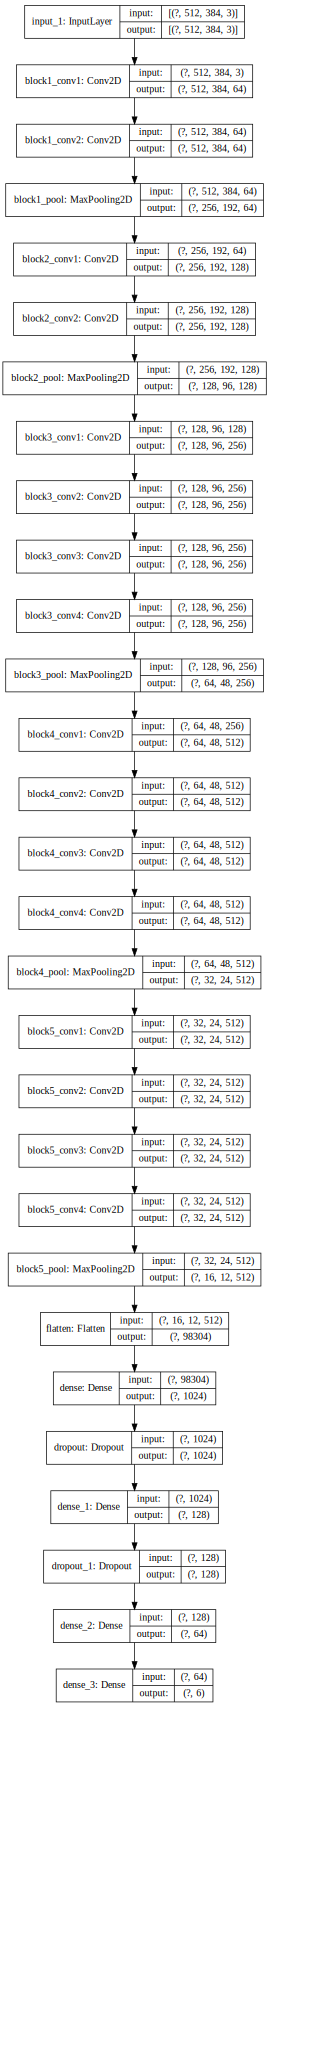

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(transferLearningModel, show_shapes=True, dpi = 60).create(prog='dot', format='svg'))


# Step7: Calculating The Classification Models Performance Metrics

### Step7.1: Printing the Accuracy (Classification Models Performance Metrics)

# 

In [ ]:
y_actual_imagesClassLabels_OneHotEncodedMatrix=test_label
print(y_actual_imagesClassLabels_OneHotEncodedMatrix)
y_actual_imagesClassLabels_OneHotEncodedMatrix.shape #2d data strucuture aka 2d-matrix

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]


(6, 6)

In [ ]:
import numpy as np

y_actual_imagesClassLabels_Vector=np.argmax(y_actual_imagesClassLabels_OneHotEncodedMatrix, axis=1)
print(y_actual_imagesClassLabels_Vector)
y_actual_imagesClassLabels_Vector.shape #1d data strucuture aka 1d-vector

[5 2 3 1 4 0]


(6,)

In [ ]:
#predict class label(by the transfer learned model) based on using the test data
y_predicted_classLabels_OneHotEncodedMatrix=transferLearningModel.predict(test_data)
print(y_predicted_classLabels_OneHotEncodedMatrix)
y_predicted_classLabels_OneHotEncodedMatrix.shape #2d data strucuture aka 2d-matrix

[[0.18561324 0.1549144  0.17984782 0.16546452 0.14363326 0.17052668]
 [0.18928841 0.15366249 0.1825372  0.1644011  0.13914682 0.17096403]
 [0.1943302  0.14922284 0.18162633 0.16463521 0.13790198 0.1722835 ]
 [0.19179712 0.15076788 0.18038543 0.16564664 0.14015043 0.17125247]
 [0.17896725 0.15788664 0.1775275  0.16835748 0.1478837  0.16937737]
 [0.19432126 0.14934239 0.18169858 0.16460088 0.1376228  0.17241414]]


(6, 6)

In [ ]:
y_predicted_classLabels_Vector = np.argmax(y_predicted_classLabels_OneHotEncodedMatrix, axis = 1)
print(y_predicted_classLabels_Vector )
y_predicted_classLabels_Vector.shape #1d data strucuture aka 1d-vector

[0 0 0 0 0 0]


(6,)

In [ ]:
from sklearn.metrics import confusion_matrix
#-------------------------------------------------------------------------------#
cm = confusion_matrix(y_actual_imagesClassLabels_Vector, y_predicted_classLabels_Vector) #1d data structures aka 1d-vectors

tn=cm[1,1]
tp=cm[0,0]
fp=cm[0,1]
fn=cm[1,0]

goodPreds=tp+tn
badPreds=fp+fn
allPreds=goodPreds+badPreds

print('\nTrue Positives:',tp)
print('True Negatives:',tn)
print('False Positives:',fp)
print('False Negatives:',fn)
print('\nTotal Predictions:',allPreds)
print('\nAccuracy (Good Prediction Rate):',(goodPreds/allPreds))
print('Misclassification (Bad Prediction Rate):',(badPreds/allPreds))


True Positives: 1
True Negatives: 0
False Positives: 0
False Negatives: 1

Total Predictions: 2

Accuracy (Good Prediction Rate): 0.5
Misclassification (Bad Prediction Rate): 0.5


### Step7.2: Printing the Classification Report (Classification Models Performance Metrics)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#6 class labels per the raw data folder structure
classLabel_Vector = ['warthog','porpucine','giraffe','gazelleThomsons','gazelleGrants','elephant']
                
ClassificationReport=classification_report(y_actual_imagesClassLabels_Vector, y_predicted_classLabels_Vector,target_names=classLabel_Vector) #1d data structures aka 1d-vectors
print('\n Classification Results:\n',ClassificationReport)


 Classification Results:
                  precision    recall  f1-score   support

        warthog       0.17      1.00      0.29         1
      porpucine       0.00      0.00      0.00         1
        giraffe       0.00      0.00      0.00         1
gazelleThomsons       0.00      0.00      0.00         1
  gazelleGrants       0.00      0.00      0.00         1
       elephant       0.00      0.00      0.00         1

       accuracy                           0.17         6
      macro avg       0.03      0.17      0.05         6
   weighted avg       0.03      0.17      0.05         6



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Step7.3: Printing the Confusion Matrix (Classification Models Performance Metrics)

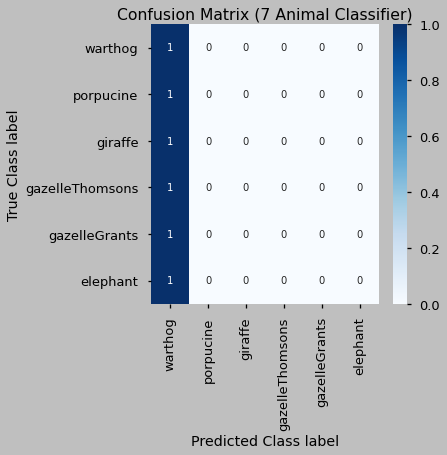

In [ ]:
cm_normalized= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
cm_df = pd.DataFrame(cm_normalized ,
                     index =classLabel_Vector,  #1d data structures aka 1d-vectors
                     columns = classLabel_Vector) #1d data structures aka 1d-vectors

import seaborn as sns
#-------------------------------------------------------------------------------#
plt.style.use(['seaborn-talk','grayscale'])
figure = plt.figure(figsize=(6, 6))
sns.heatmap(cm_df , annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix (7 Animal Classifier)')
plt.ylabel('True Class label')
plt.xlabel('Predicted Class label')
plt.show()

### Step7.4: Printing the ROC Curves of each classes (Classification Models Performance Metrics)

In [ ]:
print(y_predicted_classLabels_Vector )
y_predicted_classLabels_Vector.shape #1d data strucuture aka 1d-vector

[0 0 0 0 0 0]


(6,)

In [ ]:
from sklearn.preprocessing import label_binarize
y_predicted_classLabels_binarizedMatrix=label_binarize(y_predicted_classLabels_Vector, classes=[1,2,3,4,5,6])
y_predicted_classLabels_binarizedMatrix

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
y_predicted_classLabels_binarizedMatrix.shape

(6, 6)

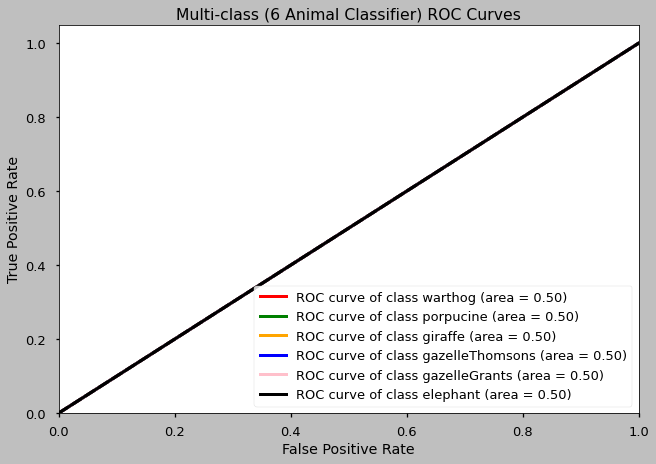

In [ ]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

#plot linewidth
lw=3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classLabel_Vector)): #1d data structures aka 1d-vectors
    fpr[i], tpr[i], _ = roc_curve(test_label[:,i],y_predicted_classLabels_binarizedMatrix[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.style.use('seaborn-talk')

colors = cycle(['red', 'green', 'orange','blue','pink','black'])

#same order as the folder structure of the raw data 
classLabel_Vector = ['warthog','porpucine','giraffe','gazelleThomsons','gazelleGrants','elephant']

for i, color in zip(range(len(classLabel_Vector)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classLabel_Vector[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class (6 Animal Classifier) ROC Curves')
plt.legend(loc="lower right")
plt.show()

### -----Understanding our transfer learning cnn model classification ability 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

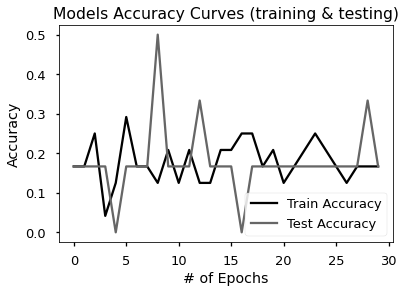

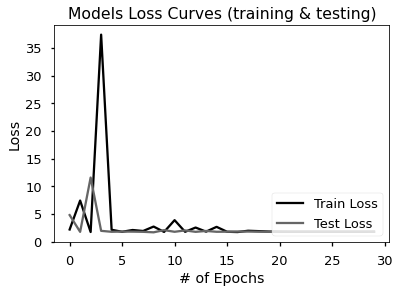

In [ ]:
#plot training & validation accuracy values
plt.plot(finalModel.history['accuracy'])
plt.plot(finalModel.history['val_accuracy'])
plt.title('Models Accuracy Curves (training & testing)')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy','Test Accuracy'], loc='lower right')
plt.show()

#plot training & validation loss values
plt.plot(finalModel.history['loss'])
plt.plot(finalModel.history['val_loss'])
plt.title('Models Loss Curves (training & testing)')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss','Test Loss'], loc='lower right')
plt.show() # OVERFITTING MODEL (training loss descreased and test loss increases)